### Try neural networks with different hyperparameters on hand-written digits dataset (Persion Digits Dataset) without using convolutional layers.

In [1]:
# Import libraries
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LeakyReLU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

2023-11-11 12:19:08.450905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 12:19:08.966172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 12:19:08.966276: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 12:19:08.969537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 12:19:09.271773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 12:19:09.273475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Download data
!gdown 1LJcwIeUsswfpAnlPtYiFkGpIhQdeFHwq

Downloading...
From (uriginal): https://drive.google.com/uc?id=1LJcwIeUsswfpAnlPtYiFkGpIhQdeFHwq
From (redirected): https://drive.google.com/uc?id=1LJcwIeUsswfpAnlPtYiFkGpIhQdeFHwq&confirm=t&uuid=a3df2461-d3bc-4154-9096-161044ff6c5b
To: /home/hossein/my-projects/hands-on-ai/Persion_hand-written_digits_classification/hoda.mat
100%|██████████████████████████████████████| 3.99M/3.99M [00:03<00:00, 1.22MB/s]


In [3]:
# Read data from .mat file
hoda = io.loadmat(file_name='hoda.mat')
hoda

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 30 20:26:30 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Data': array([[array([[  0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,
                   0,   0,   0,   0,   0,   0,   0],
                [  0,   0,   0, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
                   0,   0,   0,   0,   0,   0,   0],
                [  0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
                   0,   0,   0,   0, 255, 255,   0],
                [  0, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,
                   0,   0,   0, 255, 255, 255, 255],
                [  0, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
                   0,   0, 255, 255, 255, 255,   0],
                [  0, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                   0, 255, 255, 255, 255, 255,   0],
                [255, 255, 255, 255,   0,  

In [4]:
# Show content of hoda
hoda.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Data', 'labels'])

In [5]:
# Some cleaning
data = np.squeeze(hoda['Data'])
labels = np.squeeze(hoda['labels'])

In [6]:
X_train =  data[:40000]# Extract training data (40000 images)
y_train = labels[:40000] # Extract training labels (40000 labels)
X_valid = data[40000:50000] # Extract validation data (10000 images)
y_valid = labels[40000:50000] # Extract validation labels (10000 labels)
X_test = data[50000:60000] # Extract testing data (10000 images)
y_test = labels[50000:60000] # Extract testing labels (10000 labels)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(40000,) (40000,)
(10000,) (10000,)
(10000,) (10000,)


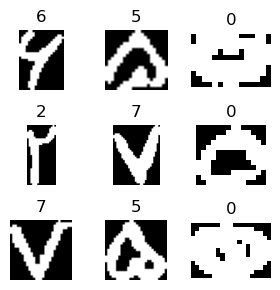

In [7]:
# plot the first 9 images in the training set in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(3, 3))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(X_train[i], cmap='gray')
  ax.axis('off')
  ax.set_title(y_train[i])
plt.tight_layout()
plt.show()

### Preprocessing

In [8]:
# Define a function to resize a single image to 62 x 62
def resize_image(img, new_w, new_h):

  current_h, current_w = img.shape
  img_resized = img.copy()
  delta_w = (new_w - current_w)
  delta_h = (new_h - current_h)

  # Check if resizing is possible
  if delta_w < 0 or delta_h < 0:
    raise ValueError("Can't resize to a lower size")

  if delta_w != 0:
    expansion_left = np.zeros((current_h, delta_w // 2))
    expansion_right = np.zeros((current_h, delta_w // 2 + (delta_w % 2) * 1))

    # Expand image horizontally to new width
    img_resized = np.hstack((expansion_left, img, expansion_right))

  if delta_h != 0:
    current_w = img_resized.shape[1]
    expansion_up = np.zeros((delta_h // 2, current_w))
    expansion_down = np.zeros((delta_h // 2 + (delta_h % 2) * 1, current_w))

    # Expand image vertically to new height
    img_resized = np.vstack(
        (expansion_up, img_resized, expansion_down)
    )

  return img_resized

resize_image(X_train[0], 62, 62).shape

(62, 62)

In [9]:
# Resize training images to 62x62
X_train_resized = np.empty((X_train.shape[0], 62, 62))
for i, img in enumerate(X_train):
  X_train_resized[i] = resize_image(img, new_w=62, new_h=62)

# Resize validation images to 62x62
X_valid_resized = np.empty((X_valid.shape[0], 62, 62))
for i, img in enumerate(X_valid):
  X_valid_resized[i] = resize_image(img, new_w=62, new_h=62)

# Resize testing images to 62x62
X_test_resized = np.empty((X_test.shape[0], 62, 62))
for i, img in enumerate(X_test):
  X_test_resized[i] = resize_image(img, new_w=62, new_h=62)

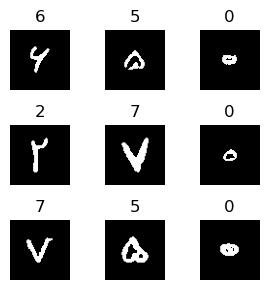

In [10]:
# plot the first 9 images in the training set in a 3x3 grid after resizing
fig, axes = plt.subplots(3, 3, figsize=(3, 3))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(X_train_resized[i], cmap='gray')
  ax.axis('off')
  ax.set_title(y_train[i])
plt.tight_layout()
plt.show()

In [11]:
# Vectorize training images
X_train_vectorized = X_train_resized.reshape(X_train.shape[0], -1)

# Vectorize validation images
X_valid_vectorized = X_valid_resized.reshape(X_valid.shape[0], -1)

# Vectorize testing images
X_test_vectorized = X_test_resized.reshape(X_test.shape[0], -1)

print(X_train_vectorized.shape)
print(X_valid_vectorized.shape)
print(X_test_vectorized.shape)

(40000, 3844)
(10000, 3844)
(10000, 3844)


In [12]:
# Normalize training images
X_train_normalized = X_train_vectorized / 255

# Normalize validation images
X_valid_normalized = X_valid_vectorized / 255

# Normalize testing images
X_test_normalized = X_test_vectorized / 255

In [13]:
# One-hot encode training labels
y_train_onehot = to_categorical(y_train)

# One-hot encode validation labels
y_valid_onehot = to_categorical(y_valid)

# One-hot encode testing labels
y_test_onehot = to_categorical(y_test)

print(y_train_onehot.shape)
print(y_valid_onehot.shape)
print(y_test_onehot.shape)

(40000, 10)
(10000, 10)
(10000, 10)


### Implement models

#### Model 1

In [14]:
model1 = Sequential()

# Add a dense layer with 64 neurons and tanh activation
model1.add(Dense(64, activation='tanh', name='Hidden'))

# Add a dense layer with 10 neurons and softmax activation
model1.add(Dense(10, activation='softmax', name='Output'))

2023-11-11 12:19:35.750289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 12:19:35.753048: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
# Compile the model
sgd_optimizer = SGD(learning_rate=0.01)
model1.compile(
    loss='categorical_crossentropy',
    optimizer=sgd_optimizer,
    metrics=['accuracy'])

# Stop training when validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
# Fit the model with training data and validation data
history1 = model1.fit(
    X_train_normalized,
    y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_data=[X_valid_normalized, y_valid_onehot],
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-11 12:19:38.255338: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615040000 exceeds 10% of free system memory.


1250/1250 [==============================] - 5s 4ms/step - loss: 0.4398 - accuracy: 0.8945 - val_loss: 0.2731 - val_accuracy: 0.9247
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2357 - accuracy: 0.9368 - val_loss: 0.2158 - val_accuracy: 0.9413
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1962 - accuracy: 0.9474 - val_loss: 0.1891 - val_accuracy: 0.9486
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1730 - accuracy: 0.9542 - val_loss: 0.1724 - val_accuracy: 0.9527
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1568 - accuracy: 0.9589 - val_loss: 0.1599 - val_accuracy: 0.9580
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1445 - accuracy: 0.9625 - val_loss: 0.1504 - val_accuracy: 0.9595
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1345 - accuracy: 0.9656 - val_loss: 0.1427 - val_accuracy: 0.96

In [17]:
# Final accuracy on validation data
loss_val1, accuracy_val1 = model1.evaluate(X_valid_normalized, y_valid_onehot)
print(f"Model 1. Validation Loss: {loss_val1:.4f}, Validation Accuracy: {accuracy_val1 * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0715 - accuracy: 0.9807
Model 1. Validation Loss: 0.0715, Validation Accuracy: 98.07%


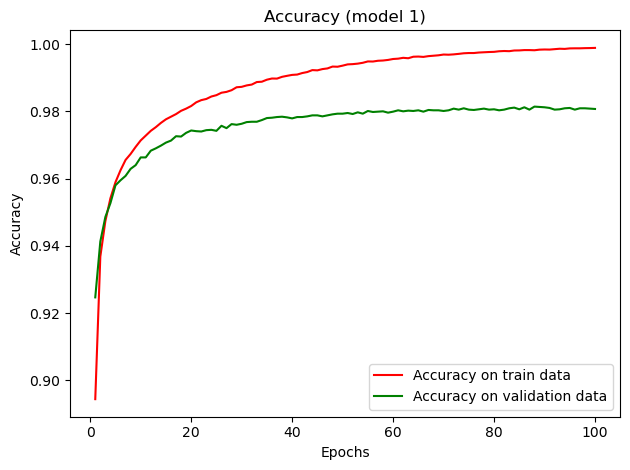

In [18]:
# Plot training and validation accuracy
tr_acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

epochs = [i + 1 for i in range(len(tr_acc1))]
plt.plot(epochs, tr_acc1, 'r', label="Accuracy on train data")
plt.plot(epochs, val_acc1, 'g', label="Accuracy on validation data")
plt.title("Accuracy (model 1)")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#### Model 2

In [19]:
model2 = Sequential()

# Add a dense layer with 64 neurons and ReLU activation
model2.add(Dense(64, activation='relu', name='Hidden'))

# Add a dense layer with 10 neurons and softmax activation
model2.add(Dense(10, activation='softmax', name='Output'))

In [20]:
# Compile the model
sgd_optimizer = SGD(learning_rate=0.01)
model2.compile(
    loss='categorical_crossentropy',
    optimizer=sgd_optimizer,
    metrics=['accuracy'])

# Stop training when validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
# Fit the model with training data and validation data
history2 = model2.fit(
    X_train_normalized,
    y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_data=[X_valid_normalized, y_valid_onehot],
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-11 12:26:10.003188: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615040000 exceeds 10% of free system memory.


1250/1250 [==============================] - 5s 4ms/step - loss: 0.4402 - accuracy: 0.8931 - val_loss: 0.2502 - val_accuracy: 0.9301
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2165 - accuracy: 0.9430 - val_loss: 0.2024 - val_accuracy: 0.9447
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1826 - accuracy: 0.9525 - val_loss: 0.1812 - val_accuracy: 0.9519
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1623 - accuracy: 0.9576 - val_loss: 0.1650 - val_accuracy: 0.9574
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1472 - accuracy: 0.9615 - val_loss: 0.1551 - val_accuracy: 0.9591
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1351 - accuracy: 0.9644 - val_loss: 0.1451 - val_accuracy: 0.9626
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1248 - accuracy: 0.9676 - val_loss: 0.1392 - val_accuracy: 0.96

In [22]:
# Final accuracy on validation data
loss_val2, accuracy_val2 = model2.evaluate(X_valid_normalized, y_valid_onehot)
print(f"Model 2. Validation Loss: {loss_val2:.4f}, Validation Accuracy: {accuracy_val2 * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0778 - accuracy: 0.9795
Model 2. Validation Loss: 0.0778, Validation Accuracy: 97.95%


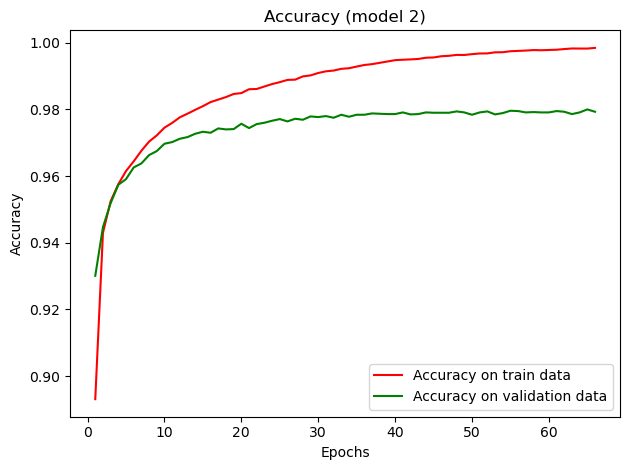

In [23]:
# Plot training and validation accuracy
tr_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs = [i + 1 for i in range(len(tr_acc2))]
plt.plot(epochs, tr_acc2, 'r', label='Accuracy on train data')
plt.plot(epochs, val_acc2, 'g', label='Accuracy on validation data')
plt.title('Accuracy (model 2)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#### Model 3

In [24]:
model3 = Sequential()

# Add a dense layer with 64 neurons and ReLU activation
model3.add(Dense(64, activation='relu', name='Hidden_1'))

# Add a dense layer with 256 neurons and ReLU activation
model3.add(Dense(256, activation='relu', name='Hidden_2'))

# Add a dense layer with 10 neurons and softmax activation
model3.add(Dense(10, activation='softmax', name='Output'))

In [25]:
# Compile the model
sgd_optimizer = SGD(learning_rate=0.01)
model3.compile(
    loss='categorical_crossentropy',
    optimizer=sgd_optimizer,
    metrics=['accuracy'])

# Stop training when validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Fit the model with training data and validation data
history3 = model3.fit(
    X_train_normalized,
    y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_data=[X_valid_normalized, y_valid_onehot],
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-11 12:30:07.191261: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615040000 exceeds 10% of free system memory.


1250/1250 [==============================] - 5s 4ms/step - loss: 0.5502 - accuracy: 0.8660 - val_loss: 0.2404 - val_accuracy: 0.9329
Epoch 2/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2030 - accuracy: 0.9439 - val_loss: 0.1873 - val_accuracy: 0.9470
Epoch 3/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.1645 - accuracy: 0.9557 - val_loss: 0.1627 - val_accuracy: 0.9550
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1418 - accuracy: 0.9626 - val_loss: 0.1451 - val_accuracy: 0.9600
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1251 - accuracy: 0.9670 - val_loss: 0.1319 - val_accuracy: 0.9633
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1112 - accuracy: 0.9703 - val_loss: 0.1237 - val_accuracy: 0.9666
Epoch 7/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0999 - accuracy: 0.9734 - val_loss: 0.1162 - val_accuracy: 0.96

In [27]:
# Final accuracy on validation data
loss_val3, accuracy_val3 = model3.evaluate(X_valid_normalized, y_valid_onehot)
print(f"Model 3. Validation Loss: {loss_val3:.4f}, Validation Accuracy: {accuracy_val3 * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0738 - accuracy: 0.9803
Model 3. Validation Loss: 0.0738, Validation Accuracy: 98.03%


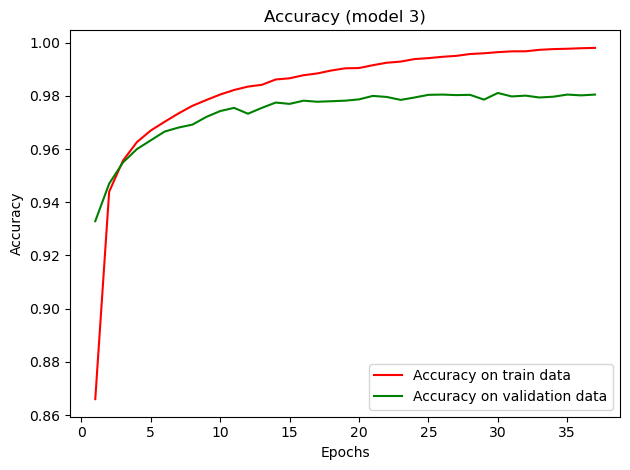

In [28]:
# Plot training and validation accuracy
tr_acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

epochs = [i + 1 for i in range(len(tr_acc3))]
plt.plot(epochs, tr_acc3, 'r', label='Accuracy on train data')
plt.plot(epochs, val_acc3, 'g', label='Accuracy on validation data')
plt.title('Accuracy (model 3)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#### Model 4

In [29]:
model4 = Sequential()

# Add a dense layer with 64 neurons and LeakyReLU activation
model4.add(Dense(64, activation=LeakyReLU(alpha=0.1), name='Hidden_1'))

# Add a dense layer with 256 neurons and LeakyReLU activation
model4.add(Dense(256, activation=LeakyReLU(alpha=0.1), name='Hidden_2'))

# Add a dense layer with 10 neurons and softmax activation
model4.add(Dense(10, activation='softmax', name='Output'))

In [30]:
# Compile the model
sgd_optimizer = SGD(learning_rate=0.01)
model4.compile(
    loss='categorical_crossentropy',
    optimizer=sgd_optimizer,
    metrics=['accuracy'])

# Stop training when validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
# Fit the model with training data and validation data
history4 = model4.fit(
    X_train_normalized,
    y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_data=[X_valid_normalized, y_valid_onehot],
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-11 12:32:38.365561: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615040000 exceeds 10% of free system memory.


1250/1250 [==============================] - 5s 4ms/step - loss: 0.5361 - accuracy: 0.8726 - val_loss: 0.2392 - val_accuracy: 0.9322
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2075 - accuracy: 0.9435 - val_loss: 0.1898 - val_accuracy: 0.9482
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1724 - accuracy: 0.9533 - val_loss: 0.1683 - val_accuracy: 0.9541
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1527 - accuracy: 0.9596 - val_loss: 0.1600 - val_accuracy: 0.9563
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1382 - accuracy: 0.9632 - val_loss: 0.1520 - val_accuracy: 0.9585
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1258 - accuracy: 0.9666 - val_loss: 0.1387 - val_accuracy: 0.9644
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1149 - accuracy: 0.9701 - val_loss: 0.1324 - val_accuracy: 0.96

In [32]:
# Final accuracy on validation data
loss_val4, accuracy_val4 = model4.evaluate(X_valid_normalized, y_valid_onehot)
print(f"Model 4. Validation Loss: {loss_val4:.4f}, Validation Accuracy: {accuracy_val4 * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0806 - accuracy: 0.9783
Model 4. Validation Loss: 0.0806, Validation Accuracy: 97.83%


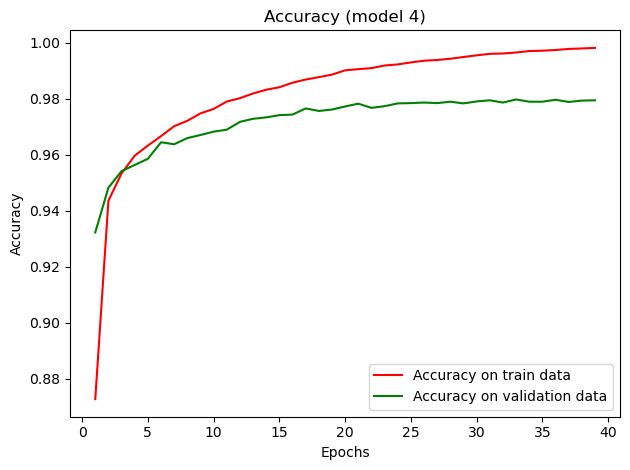

In [33]:
# Plot training and validation accuracy
tr_acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']

epochs = [i + 1 for i in range(len(tr_acc4))]
plt.plot(epochs, tr_acc4, 'r', label='Accuracy on train data')
plt.plot(epochs, val_acc4, 'g', label='Accuracy on validation data')
plt.title('Accuracy (model 4)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### Compare models

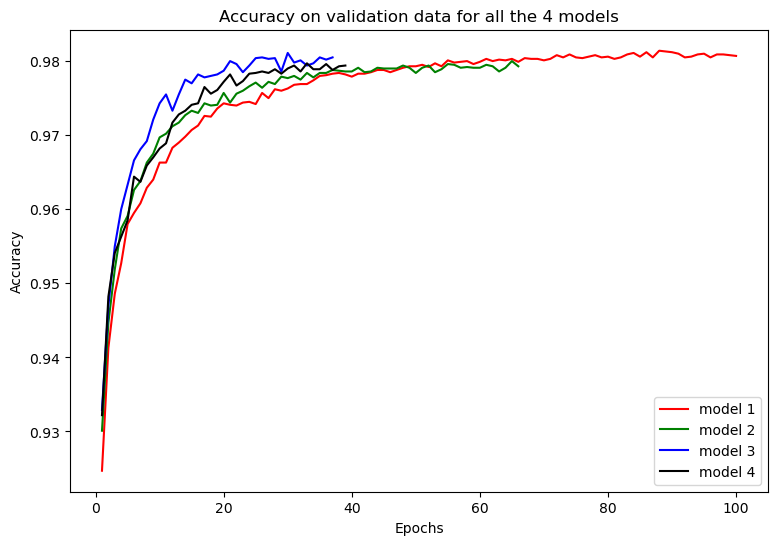

In [34]:
# To-Do (Plot validation accuracy of all models)
val_accs = [val_acc1, val_acc2, val_acc3, val_acc4]
epochs = [
  [i + 1 for i in range(len(val_acc1))], 
  [i + 1 for i in range(len(val_acc2))],
  [i + 1 for i in range(len(val_acc3))],
  [i + 1 for i in range(len(val_acc4))],
]

model_colors = ['red', 'green', 'blue', 'black']

plt.figure(figsize=(9, 6))
for i, val_acc in enumerate(val_accs):
  plt.plot(epochs[i], val_accs[i], model_colors[i], label=f'model {i + 1}')

plt.title('Accuracy on validation data for all the 4 models')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium; color:#0099cc"><font face="vazir" size=5><i>
Conclusion:
According to the accuracy of the models on the validation data, it can be concluded that the difference of hyperparameters in these four models does not create a significant difference on the accuracy of the model on the validation data (the final accuracy of all 4 models on the validation data is very close to % 98). But by comparing the accuracy of the models in each round in the graph above, it seems that the difference of hyperparameters in these four models has caused a slight change in their convergence speed; In other words, the speed of convergence of model number 1 is a little lower than the other 3 models, and it also seems that the speed of convergence of model number 3 is the highest.
</i></font></p>

#### Find a better model

In [35]:
# Further tuning of hyperparameters)
final_model = Sequential()

# Add a dense layer with 64 neurons and ReLU activation
final_model.add(
    Dense(128, activation='relu', kernel_initializer='he_normal', name='Hidden_1'))

# Add a droupout layer with 20% dropout rate
final_model.add(Dropout(0.1, name='Dropout_1'))

# Add a dense layer with 256 neurons and ReLU activation
final_model.add(
    Dense(400, activation='relu', kernel_initializer='he_normal', name='Hidden_2'))

# Add a droupout layer with 20% dropout rate
# final_model.add(Dropout(0.1, name='Dropout_2'))

# Add a dense layer with 10 neurons and softmax activation
final_model.add(Dense(10, activation='softmax', name='Output'))


# Compile the model
adam_optimizer = Adam(learning_rate=0.001)
final_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Stop training when validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history_final = final_model.fit(
    X_train_normalized,
    y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_data=[X_valid_normalized, y_valid_onehot],
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-11 12:35:11.690028: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 615040000 exceeds 10% of free system memory.


1250/1250 [==============================] - 10s 7ms/step - loss: 0.1647 - accuracy: 0.9524 - val_loss: 0.0831 - val_accuracy: 0.9749
Epoch 2/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0658 - accuracy: 0.9796 - val_loss: 0.0772 - val_accuracy: 0.9785
Epoch 3/100
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0477 - accuracy: 0.9847 - val_loss: 0.0632 - val_accuracy: 0.9838
Epoch 4/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.0857 - val_accuracy: 0.9797
Epoch 5/100
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0321 - accuracy: 0.9898 - val_loss: 0.0728 - val_accuracy: 0.9817
Epoch 6/100
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0288 - accuracy: 0.9904 - val_loss: 0.0857 - val_accuracy: 0.9820
Epoch 7/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0230 - accuracy: 0.9924 - val_loss: 0.0901 - val_accuracy: 0.9

In [36]:
# Final accuracy on validation data
loss_val_final, accuracy_val_final = final_model.evaluate(X_valid_normalized, y_valid_onehot)
print(f"Final Model. Validation Loss: {loss_val_final:.4f}, Validation Accuracy: {accuracy_val_final * 100:.2f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0632 - accuracy: 0.9838
Final Model. Validation Loss: 0.0632, Validation Accuracy: 98.38%


### Evalustion on test dataset

In [37]:
# Final metrics on testing data

# Predict on testing data
y_pred = final_model.predict(X_test_normalized)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Report
print(classification_report(y_true, y_pred))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       975
           1       0.99      1.00      0.99       999
           2       0.97      0.97      0.97       992
           3       0.96      0.98      0.97      1005
           4       0.98      0.96      0.97       991
           5       0.99      0.99      0.99      1020
           6       0.99      0.97      0.98       992
           7       0.99      0.99      0.99      1006
           8       0.99      0.99      0.99      1024
           9       0.97      0.99      0.98       996

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



<Axes: >

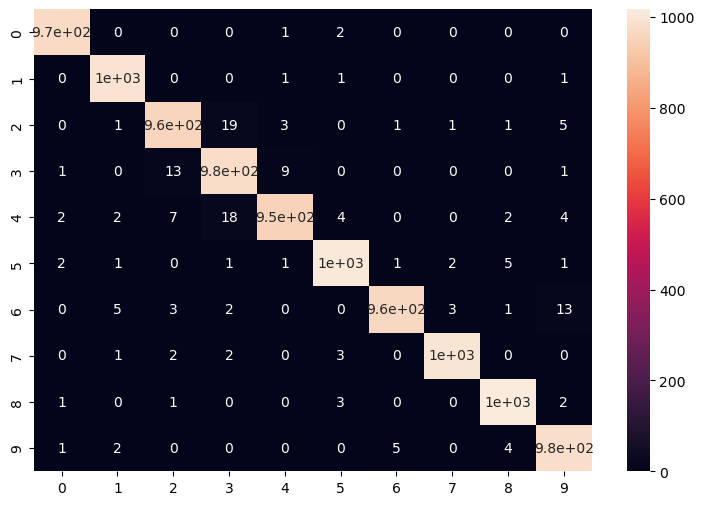

In [38]:
# Draw confusion matrix
plt.figure(figsize=(9, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)